In [1]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '.drive/My Drive/'

%cd './drive/My Drive/Colab Notebooks/clean_dirty_net'
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/clean_dirty_net
create_val_dir.py  plates		  submission_87.csv
my_net.ipynb	   same_net.py		  submission.csv
my_net.py	   sample_submission.csv  submission_test.csv


In [0]:
import numpy as np
import pandas as pd
import os
import torchvision as tv
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import random


random.seed(6)
np.random.seed(6)
torch.manual_seed(6)
torch.cuda.manual_seed(6)
torch.backends.cudnn.deterministic = True

data_root = './plates/plates/'
train_dir = data_root + 'train'
val_dir = data_root + 'test'
test_dir = './plates/test'

class_names = ['cleaned', 'dirty']

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [0]:
class ImageFolderWithPaths(tv.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [0]:
def show_input(input_tensor, title=''):
    if type(input_tensor) != 'numpy.ndarray':
        input_tensor = input_tensor.numpy()
    image = input_tensor.transpose(1, 2, 0)
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

In [0]:
class CleanDirtyNet(torch.nn.Module):
    def __init__(self, train_dataloader, val_dataloader, epoch_size=50):
        super(CleanDirtyNet, self).__init__()
        self._submodel = tv.models.resnet18(pretrained=True)
        for param in self._submodel.parameters():
            # param.
            param.requires_grad = False
        self._submodel.fc = torch.nn.Linear(self._submodel.fc.in_features, self._submodel.fc.out_features)
        self._device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self._fc1 = torch.nn.Linear(in_features=1000, out_features=50)
        self._fc2 = torch.nn.Linear(in_features=50, out_features=2)
        # self._fc3 = torch.nn.Linear(in_features=10, out_features=2)
        self._relu = torch.nn.LeakyReLU(inplace=True)
        self._train(train_dataloader, val_dataloader, epoch_size)

    def _forward(self, x):
        x = self._submodel(x)
        x = self._relu(x)
        x = self._fc1(x)
        x = self._relu(x)
        x = self._fc2(x)
        # x = self._relu(x)
        # x = self._fc3(x)
        return x
    
    def _train(self, train_dataloader, val_dataloader, epoch_size):
        statistics = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1.0e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        self = self.to(self._device)
        self.train()
        for epoch in range(epoch_size):
            print('Epoch {}/{}:'.format(epoch+1, epoch_size), flush=True)
            for phase in ['train', 'val']:
                if phase == 'train':
                    dataloader = train_dataloader
                    scheduler.step()
                    self.train()
                else:
                    dataloader = val_dataloader
                    self.eval()
                running_loss = 0.
                running_acc = 0.
                for inputs, labels in tqdm(dataloader):
                    inputs = inputs.to(self._device)
                    labels = labels.to(self._device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        preds = self._forward(inputs)
                        loss_value = loss(preds, labels)
                        preds_class = preds.argmax(dim=1)
                        if phase == 'train':
                            loss_value.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss_value.item()
                    running_acc += (preds_class == labels.data).float().mean()

                epoch_loss = running_loss / len(dataloader)
                epoch_acc = running_acc / len(dataloader)
                if phase == 'train':
                    statistics['train_loss'].append(epoch_loss)
                    statistics['train_acc'].append(epoch_acc.item())
                else:
                    statistics['val_loss'].append(epoch_loss)
                    statistics['val_acc'].append(epoch_acc.item())
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
            print()    
            
        self.eval()
        statistics = pd.DataFrame(statistics)
        statistics.plot(y=['val_loss', 'train_loss'])
        plt.show()

    def predict(self, dataloader):
        test_predictions = []
        test_img_paths = []
        for inputs, labels, paths in tqdm(dataloader):
            inputs = inputs.to(self._device)
            labels = labels.to(self._device)
            with torch.set_grad_enabled(False):
                preds = self._forward(inputs)
            test_predictions.append(
                preds.argmax(dim=1).data.cpu().numpy()
                # torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()
            )
            test_img_paths.extend(paths)
            
        test_predictions = np.concatenate(test_predictions)

        # if need_show_input:
        #     for img, pred in zip(test_inputs, test_predictions):
        #         show_input(img, title=pred)

        return test_img_paths, test_predictions

train tensor lenght: 15
validation tensor lenght: 13


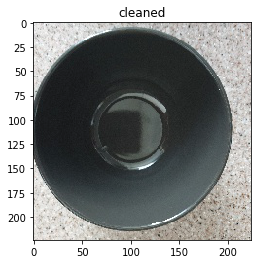

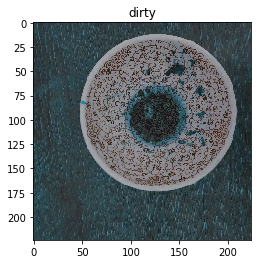

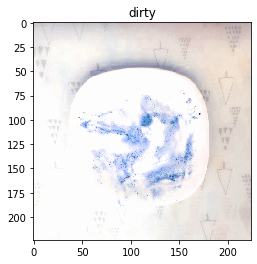

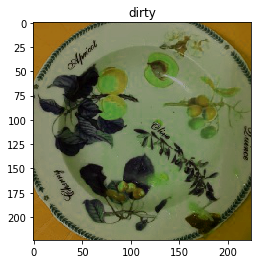

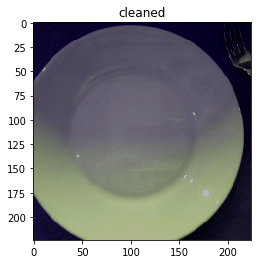

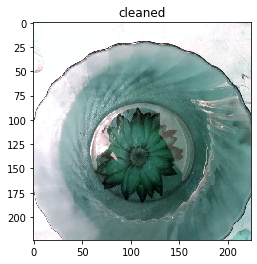

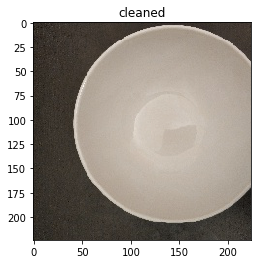

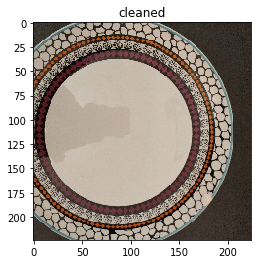

In [6]:
train_transform = tv.transforms.Compose([
    tv.transforms.RandomApply([
        tv.transforms.ColorJitter(
            brightness=0.5,
            contrast=0.5,
            saturation=0.5,
            hue=0.5
        )
    ]),
    tv.transforms.RandomVerticalFlip(p=0.5),
    tv.transforms.CenterCrop(224),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])
val_transforms = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean, std)
])

train_dataset = torch.utils.data.ConcatDataset([
    # tv.datasets.ImageFolder(train_dir, train_transform),
    # tv.datasets.ImageFolder(train_dir, train_transform),
    # tv.datasets.ImageFolder(train_dir, train_transform),
    # tv.datasets.ImageFolder(train_dir, train_transform),
    # tv.datasets.ImageFolder(train_dir, train_transform),
    tv.datasets.ImageFolder(train_dir, train_transform),
    tv.datasets.ImageFolder(train_dir, train_transform),
    tv.datasets.ImageFolder(train_dir, train_transform)
])
val_dataset = tv.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

print("train tensor lenght: {}".format(len(train_dataloader)))
print("validation tensor lenght: {}".format(len(val_dataloader)))

if True:
    X_batch, y_batch = next(iter(train_dataloader))
    for x_item, y_item in zip(X_batch, y_batch):
        show_input(x_item, title=class_names[y_item])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 26.5MB/s]


Epoch 1/50:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 15/15 [00:01<00:00, 10.03it/s]

train Loss: 0.7489 Acc: 0.5250



100%|██████████| 13/13 [00:08<00:00,  1.50it/s]

val Loss: 0.6089 Acc: 0.7019

Epoch 2/50:



100%|██████████| 15/15 [00:01<00:00, 10.79it/s]

train Loss: 0.6000 Acc: 0.7250



100%|██████████| 13/13 [00:00<00:00, 14.02it/s]

val Loss: 0.4897 Acc: 0.9615

Epoch 3/50:



100%|██████████| 15/15 [00:01<00:00,  3.02it/s]

train Loss: 0.5591 Acc: 0.7500



100%|██████████| 13/13 [00:00<00:00, 14.26it/s]

val Loss: 0.2913 Acc: 0.9519

Epoch 4/50:



100%|██████████| 15/15 [00:01<00:00, 10.98it/s]

train Loss: 0.3817 Acc: 0.8167



100%|██████████| 13/13 [00:00<00:00, 14.05it/s]

val Loss: 0.2980 Acc: 0.8942

Epoch 5/50:



100%|██████████| 15/15 [00:01<00:00,  4.59it/s]

train Loss: 0.3773 Acc: 0.8250



100%|██████████| 13/13 [00:00<00:00, 13.56it/s]

val Loss: 0.1796 Acc: 0.9712

Epoch 6/50:



100%|██████████| 15/15 [00:01<00:00, 10.28it/s]

train Loss: 0.4408 Acc: 0.7417



100%|██████████| 13/13 [00:00<00:00, 13.94it/s]

val Loss: 0.2406 Acc: 0.9423

Epoch 7/50:



100%|██████████| 15/15 [00:01<00:00, 10.95it/s]

train Loss: 0.3497 Acc: 0.8250



100%|██████████| 13/13 [00:00<00:00, 13.79it/s]

val Loss: 0.1852 Acc: 0.9615

Epoch 8/50:



100%|██████████| 15/15 [00:01<00:00, 10.76it/s]

train Loss: 0.1846 Acc: 0.9750



100%|██████████| 13/13 [00:00<00:00, 13.88it/s]

val Loss: 0.2016 Acc: 0.8846

Epoch 9/50:



100%|██████████| 15/15 [00:01<00:00, 11.02it/s]

train Loss: 0.3254 Acc: 0.8667



100%|██████████| 13/13 [00:00<00:00, 13.90it/s]

val Loss: 0.1612 Acc: 0.9615

Epoch 10/50:



100%|██████████| 15/15 [00:01<00:00, 11.00it/s]

train Loss: 0.1735 Acc: 0.9417



100%|██████████| 13/13 [00:00<00:00, 13.80it/s]

val Loss: 0.1819 Acc: 0.8846

Epoch 11/50:



100%|██████████| 15/15 [00:01<00:00, 10.84it/s]

train Loss: 0.1820 Acc: 0.9333



100%|██████████| 13/13 [00:00<00:00, 13.66it/s]

val Loss: 0.1774 Acc: 0.9038

Epoch 12/50:



100%|██████████| 15/15 [00:01<00:00,  4.67it/s]

train Loss: 0.2330 Acc: 0.9333



100%|██████████| 13/13 [00:00<00:00, 13.27it/s]

val Loss: 0.1722 Acc: 0.8942

Epoch 13/50:



100%|██████████| 15/15 [00:01<00:00, 10.79it/s]

train Loss: 0.2096 Acc: 0.9333



100%|██████████| 13/13 [00:00<00:00, 13.40it/s]

val Loss: 0.1571 Acc: 0.9231

Epoch 14/50:



100%|██████████| 15/15 [00:01<00:00, 10.19it/s]

train Loss: 0.3147 Acc: 0.8417



100%|██████████| 13/13 [00:00<00:00, 13.34it/s]

val Loss: 0.1491 Acc: 0.9423

Epoch 15/50:



100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


train Loss: 0.1813 Acc: 0.9167


100%|██████████| 13/13 [00:00<00:00, 13.62it/s]

val Loss: 0.1893 Acc: 0.8846

Epoch 16/50:



100%|██████████| 15/15 [00:01<00:00, 10.68it/s]

train Loss: 0.2267 Acc: 0.9167



100%|██████████| 13/13 [00:00<00:00, 13.28it/s]

val Loss: 0.1688 Acc: 0.9038

Epoch 17/50:



100%|██████████| 15/15 [00:01<00:00,  4.86it/s]

train Loss: 0.1316 Acc: 0.9750



100%|██████████| 13/13 [00:00<00:00,  3.22it/s]

val Loss: 0.1583 Acc: 0.9135

Epoch 18/50:



100%|██████████| 15/15 [00:01<00:00, 10.57it/s]

train Loss: 0.2089 Acc: 0.8917



100%|██████████| 13/13 [00:00<00:00,  3.30it/s]

val Loss: 0.1460 Acc: 0.9423

Epoch 19/50:



100%|██████████| 15/15 [00:01<00:00, 11.20it/s]

train Loss: 0.1531 Acc: 0.9417



100%|██████████| 13/13 [00:00<00:00, 13.30it/s]


val Loss: 0.1684 Acc: 0.9135

Epoch 20/50:


100%|██████████| 15/15 [00:01<00:00, 10.86it/s]

train Loss: 0.1888 Acc: 0.9333



100%|██████████| 13/13 [00:00<00:00, 13.73it/s]

val Loss: 0.1508 Acc: 0.9327

Epoch 21/50:



100%|██████████| 15/15 [00:01<00:00, 10.87it/s]

train Loss: 0.3217 Acc: 0.8750



100%|██████████| 13/13 [00:00<00:00, 13.72it/s]

val Loss: 0.1671 Acc: 0.9135

Epoch 22/50:



100%|██████████| 15/15 [00:01<00:00, 10.68it/s]

train Loss: 0.1206 Acc: 0.9750



100%|██████████| 13/13 [00:00<00:00, 13.77it/s]

val Loss: 0.1592 Acc: 0.9231

Epoch 23/50:



100%|██████████| 15/15 [00:01<00:00, 10.49it/s]

train Loss: 0.2177 Acc: 0.9167



100%|██████████| 13/13 [00:00<00:00, 13.74it/s]

val Loss: 0.1577 Acc: 0.9327

Epoch 24/50:



100%|██████████| 15/15 [00:01<00:00,  3.31it/s]

train Loss: 0.2733 Acc: 0.8667



100%|██████████| 13/13 [00:00<00:00, 13.56it/s]

val Loss: 0.1637 Acc: 0.9135

Epoch 25/50:



100%|██████████| 15/15 [00:01<00:00, 10.36it/s]

train Loss: 0.2271 Acc: 0.9000



100%|██████████| 13/13 [00:00<00:00, 14.07it/s]

val Loss: 0.1727 Acc: 0.9038

Epoch 26/50:



100%|██████████| 15/15 [00:01<00:00, 10.77it/s]

train Loss: 0.2410 Acc: 0.8917



100%|██████████| 13/13 [00:00<00:00, 13.67it/s]

val Loss: 0.1846 Acc: 0.8846

Epoch 27/50:



100%|██████████| 15/15 [00:01<00:00, 10.62it/s]

train Loss: 0.2352 Acc: 0.8833



100%|██████████| 13/13 [00:01<00:00, 12.96it/s]

val Loss: 0.1648 Acc: 0.9135

Epoch 28/50:



100%|██████████| 15/15 [00:01<00:00,  4.66it/s]

train Loss: 0.1666 Acc: 0.9500



100%|██████████| 13/13 [00:00<00:00, 13.62it/s]

val Loss: 0.1645 Acc: 0.9231

Epoch 29/50:



100%|██████████| 15/15 [00:01<00:00, 10.19it/s]

train Loss: 0.1823 Acc: 0.9500



100%|██████████| 13/13 [00:00<00:00, 13.76it/s]

val Loss: 0.1750 Acc: 0.8846

Epoch 30/50:



100%|██████████| 15/15 [00:01<00:00, 10.25it/s]

train Loss: 0.2161 Acc: 0.9083



100%|██████████| 13/13 [00:00<00:00, 13.47it/s]

val Loss: 0.1480 Acc: 0.9327

Epoch 31/50:



100%|██████████| 15/15 [00:01<00:00,  4.30it/s]

train Loss: 0.2003 Acc: 0.9167



100%|██████████| 13/13 [00:00<00:00, 13.60it/s]

val Loss: 0.1619 Acc: 0.9135

Epoch 32/50:



100%|██████████| 15/15 [00:01<00:00,  4.72it/s]

train Loss: 0.1723 Acc: 0.9500



100%|██████████| 13/13 [00:00<00:00, 13.69it/s]

val Loss: 0.1566 Acc: 0.9231

Epoch 33/50:



100%|██████████| 15/15 [00:01<00:00, 10.85it/s]

train Loss: 0.2323 Acc: 0.9167



100%|██████████| 13/13 [00:00<00:00, 13.50it/s]

val Loss: 0.1686 Acc: 0.8942

Epoch 34/50:



100%|██████████| 15/15 [00:01<00:00, 11.17it/s]

train Loss: 0.1588 Acc: 0.9500



100%|██████████| 13/13 [00:00<00:00,  3.22it/s]

val Loss: 0.1524 Acc: 0.9327

Epoch 35/50:



100%|██████████| 15/15 [00:01<00:00,  6.87it/s]

train Loss: 0.1601 Acc: 0.9333



100%|██████████| 13/13 [00:00<00:00, 14.02it/s]

val Loss: 0.1466 Acc: 0.9423

Epoch 36/50:



100%|██████████| 15/15 [00:01<00:00,  4.34it/s]

train Loss: 0.1807 Acc: 0.9583



100%|██████████| 13/13 [00:00<00:00, 13.97it/s]

val Loss: 0.1574 Acc: 0.9231

Epoch 37/50:



100%|██████████| 15/15 [00:01<00:00,  6.51it/s]

train Loss: 0.1776 Acc: 0.9417



100%|██████████| 13/13 [00:00<00:00, 13.86it/s]

val Loss: 0.1498 Acc: 0.9231

Epoch 38/50:



100%|██████████| 15/15 [00:01<00:00, 11.07it/s]


train Loss: 0.2480 Acc: 0.8917


100%|██████████| 13/13 [00:00<00:00, 13.77it/s]

val Loss: 0.1696 Acc: 0.8942

Epoch 39/50:



100%|██████████| 15/15 [00:01<00:00, 10.94it/s]

train Loss: 0.2106 Acc: 0.8917



100%|██████████| 13/13 [00:00<00:00,  3.30it/s]

val Loss: 0.1865 Acc: 0.8846

Epoch 40/50:



100%|██████████| 15/15 [00:01<00:00, 10.78it/s]

train Loss: 0.1642 Acc: 0.9667



100%|██████████| 13/13 [00:00<00:00, 14.31it/s]

val Loss: 0.1644 Acc: 0.9038

Epoch 41/50:



100%|██████████| 15/15 [00:01<00:00,  4.54it/s]

train Loss: 0.2112 Acc: 0.9333



100%|██████████| 13/13 [00:00<00:00, 13.89it/s]

val Loss: 0.1594 Acc: 0.9135



Epoch 42/50:


100%|██████████| 15/15 [00:01<00:00, 10.42it/s]

train Loss: 0.1595 Acc: 0.9500



100%|██████████| 13/13 [00:00<00:00, 13.97it/s]

val Loss: 0.1431 Acc: 0.9519

Epoch 43/50:



100%|██████████| 15/15 [00:01<00:00, 10.85it/s]

train Loss: 0.1539 Acc: 0.9583



100%|██████████| 13/13 [00:00<00:00, 14.17it/s]

val Loss: 0.1547 Acc: 0.9327

Epoch 44/50:



100%|██████████| 15/15 [00:01<00:00, 10.16it/s]

train Loss: 0.2128 Acc: 0.9333



100%|██████████| 13/13 [00:00<00:00, 13.95it/s]

val Loss: 0.1670 Acc: 0.8942

Epoch 45/50:



100%|██████████| 15/15 [00:01<00:00, 11.04it/s]

train Loss: 0.2166 Acc: 0.9000



100%|██████████| 13/13 [00:00<00:00, 13.76it/s]

val Loss: 0.1841 Acc: 0.8846

Epoch 46/50:



100%|██████████| 15/15 [00:01<00:00, 10.55it/s]

train Loss: 0.2269 Acc: 0.9333



100%|██████████| 13/13 [00:00<00:00, 14.23it/s]

val Loss: 0.1564 Acc: 0.9231

Epoch 47/50:



100%|██████████| 15/15 [00:01<00:00, 11.93it/s]


train Loss: 0.2579 Acc: 0.8833


100%|██████████| 13/13 [00:00<00:00, 14.18it/s]

val Loss: 0.1665 Acc: 0.8942

Epoch 48/50:



100%|██████████| 15/15 [00:01<00:00, 11.43it/s]

train Loss: 0.2154 Acc: 0.9000



100%|██████████| 13/13 [00:00<00:00, 14.04it/s]

val Loss: 0.1602 Acc: 0.9231

Epoch 49/50:



100%|██████████| 15/15 [00:01<00:00, 10.72it/s]

train Loss: 0.3031 Acc: 0.8833



100%|██████████| 13/13 [00:00<00:00, 14.05it/s]

val Loss: 0.1518 Acc: 0.9327

Epoch 50/50:



100%|██████████| 15/15 [00:01<00:00,  4.24it/s]

train Loss: 0.1723 Acc: 0.9583



100%|██████████| 13/13 [00:00<00:00,  4.75it/s]

val Loss: 0.1514 Acc: 0.9327


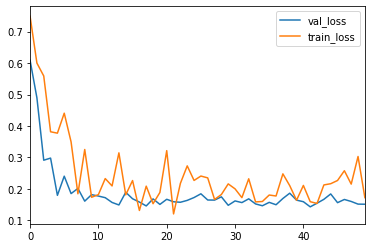

In [7]:
my_net2 = CleanDirtyNet(train_dataloader, val_dataloader, epoch_size=50)

In [0]:
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

100%|██████████| 93/93 [00:48<00:00,  1.93it/s]


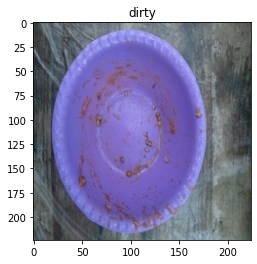

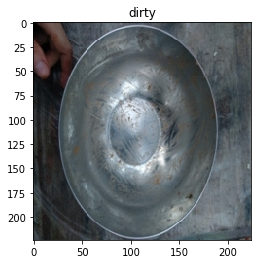

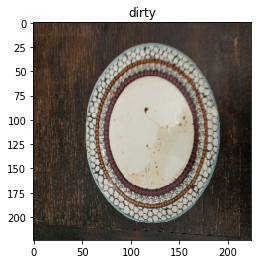

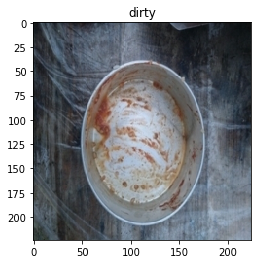

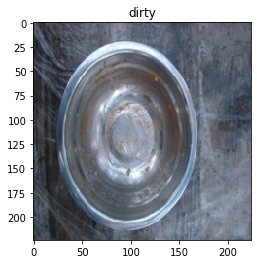

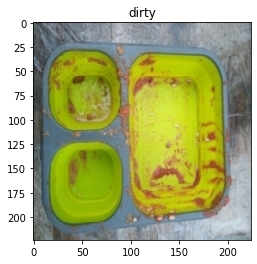

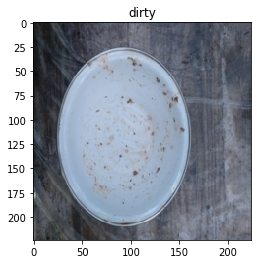

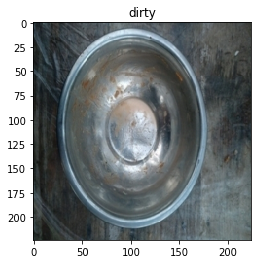

In [9]:
test_img_paths, test_predictions = my_net2.predict(test_dataloader)

if True:
    inputs, labels, paths = next(iter(test_dataloader))
    for img, pred in zip(inputs, map(lambda x: class_names[x], test_predictions)):
        show_input(img, title=pred)

In [0]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('./plates/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head()

submission_df.to_csv('submission_test.csv')